# Model Analysis

The script guides through the counting of reactions in each compartment and the generation of the Venn diagramm for reaction overlap of the two K. phaffii models iMT1026, iRY1243 and the O. polymorpha model iUL909.

In [122]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
import os
import xlrd
import pandas as pd
import re
from datetime import date
import numpy as np

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from iambcodes import countCinFormula, set_ObjGSMM, set_SubFlux, CreateTransReact

Today = date.today().strftime('%y%m%d')
FigureType = 'pdf'

In [123]:

def set_SubiOpol(model, Sub, Flux):
    '''
    Setting the desired substrate in the model.
    
    Arguments:
    model: cobra model, iOpol909
    Sub: string/list, model metabolite ID
    Flux: float, desired substrate uptake rate
    
    Return:
    cobra model, updated with designed (co-) substrate uptake rates.
    '''
    model.reactions.get_by_id('Ex_glc_D').lower_bound = 0
    model.reactions.get_by_id('Ex_{}'.format(Sub[0])).lower_bound = -Flux
    return model

In [124]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'Simulation'
iUL909_File = os.path.join('..','model','iUL909.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
model = read_sbml_model(iUL909_File)

# iMT1026_File = os.path.join('..','data','ReferenceModels','iMT1026v3.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
# iMT1026 = read_sbml_model(iMT1026_File)

# iRY1243_File = os.path.join('..','data','ReferenceModels','iRY1243.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
# iRY1243 = read_sbml_model(iRY1243_File)


## Adding reactions

In [125]:

# more realistic fluxes by forcing TCA activity
model.reactions.get_by_id('MDH').bounds = 0,0
model.reactions.get_by_id('AKGMALtm').bounds = 0,0

ID = 'IPSYN'
if ID not in model.reactions:
    reaction = Reaction(ID)
    reaction.name = 'Isoprene synthase'
    reaction.lower_bound = 0.
    reaction.upper_bound = 1000.
#     reaction.annotation = {'biocyc': 'FUCISOM-RXN', 'brenda': '5.3.1.25'}
    IP = Metabolite(
        'isoprene[c]',
        formula = 'C5H8',
        name = 'Isoprene',
        charge = 0,
        compartment = 'c',
    )
#     IP.annotation = {'biocyc':'CPD-10329', 'chebi':'42548', 'chemspider':'388645', 'drugbank':'DB04473', 'inchi':'InChI=1S/C6H12O5/c1-2-3(7)4(8)5(9)6(10)11-2/h2-10H,1H3/t2-,3+,4+,5-,6+/m0/s1', 'kegg.compound':'C20835', 'pubchem':'439554'}    
    IPP = model.metabolites.get_by_id('ipdp[c]')
    DP = model.metabolites.get_by_id('ppi[c]')
    reaction.add_metabolites({IPP:-1., IP:1., DP:1.})
    model.add_reactions([reaction])

    print(model.reactions.get_by_id(ID).id)
    print(model.reactions.get_by_id(ID).reaction)
    print(model.reactions.get_by_id(ID).check_mass_balance())
# Isoprene transport reaction
TransIso = CreateTransReact(model.metabolites.get_by_id('isoprene[c]'),'[]')
model.add_reactions([TransIso])
model.add_boundary(model.metabolites.get_by_id('isoprene[e]'), type="exchange", lb=0)

# Acetone production
# Acetoacetyl-CoA hydrolase
# https://biocyc.org/META/NEW-IMAGE?type=REACTION&object=ACETOACETYL-COA-HYDROLASE-RXN
ID = 'AcAcCoAHYD'
if ID not in model.reactions:
    reaction = Reaction(ID)
    reaction.name = 'Acetoacetyl-CoA Hydrolase'
    reaction.lower_bound = 0.
    reaction.upper_bound = 1000.
    reaction.annotation = {'biocyc': 'ACETOACETYL-COA-HYDROLASE-RXN', 'brenda': '3.1.2.11'}
    model.add_reactions([reaction])
    model.reactions.get_by_id(ID).build_reaction_from_string('aacoa[c] + h2o[c] --> acac[c] + coa[c] + h[c]')

    print(reaction.id)
    print(reaction.reaction)
    print(model.reactions.get_by_id(ID).check_mass_balance())

# Acetoacetate decarboxylase
# https://biocyc.org/META/NEW-IMAGE?type=REACTION&object=ACETOACETATE-DECARBOXYLASE-RXN
ID = 'ACACDECARB'
if ID not in model.reactions:
    reaction = Reaction(ID)
    reaction.name = 'Acetoacetate decarboxylase'
    reaction.lower_bound = 0.
    reaction.upper_bound = 1000.
    reaction.annotation = {'biocyc': 'ACETOACETATE-DECARBOXYLASE-RXN', 'brenda': '4.1.1.4'}
    ACONE = Metabolite(
        'acetone[c]',
        formula = 'C3H6O',
        name = 'Acetone',
        charge = 0,
        compartment = 'c',
    )
    ACONE.annotation = {'biocyc':'ACETONE', 'chebi':'15347', 'kegg.compound':'C00207', 'pubchem':'180'}    
    CO2 = model.metabolites.get_by_id('co2[c]')
    ACAC = model.metabolites.get_by_id('acac[c]')
    H = model.metabolites.get_by_id('h[c]')
    reaction.add_metabolites({ACAC:-1., H:-1., ACONE:1., CO2:1.})
    model.add_reactions([reaction])

    print(model.reactions.get_by_id(ID).id)
    print(model.reactions.get_by_id(ID).reaction)
    print(model.reactions.get_by_id(ID).check_mass_balance())

# Acetone transport reaction
TransAcetone = CreateTransReact(model.metabolites.get_by_id('acetone[c]'),'[]')
model.add_reactions([TransAcetone])
model.add_boundary(model.metabolites.get_by_id('acetone[e]'), type="exchange", lb=0)


IPSYN
ipdp[c] --> isoprene[c] + ppi[c]
{}
AcAcCoAHYD
aacoa[c] + h2o[c] --> acac[c] + coa[c] + h[c]
{}
ACACDECARB
acac[c] + h[c] --> acetone[c] + co2[c]
{}


Reaction identifier,EX_acetone[e]
Name,Acetone exchange
Memory address,0x07f9c23931670
Stoichiometry,acetone[e] --> Acetone -->
GPR,
Lower bound,0
Upper bound,1000.0


### Effect of ATP maintenance on production

/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


-0.011860540892798971 0.5413927530056566


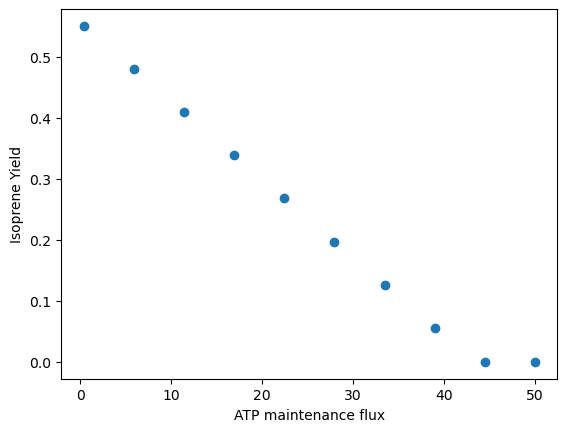

In [129]:
atpm = np.linspace(.4,50,10)
Substrate = 'meoh'
Product = 'isoprene[c]' #isoprene[c], succ[c]
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
IP_List = list()
flux=10
for atpmi in atpm:
    with model as md:
        md.reactions.get_by_id('ATPM').lower_bound = atpmi
        md = set_ObjGSMM(md, Product)
        md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        IP_List.append([atpmi, Yield])
data = np.array(IP_List)
m,b = np.polyfit(data[:,0], data[:,1], 1)
print(m,b)
plt.scatter(data[:,0], data[:,1])
plt.xlabel('ATP maintenance flux')
plt.ylabel('Isoprene Yield')
plt.show()

-3.448505841374662 0.5103215060768006


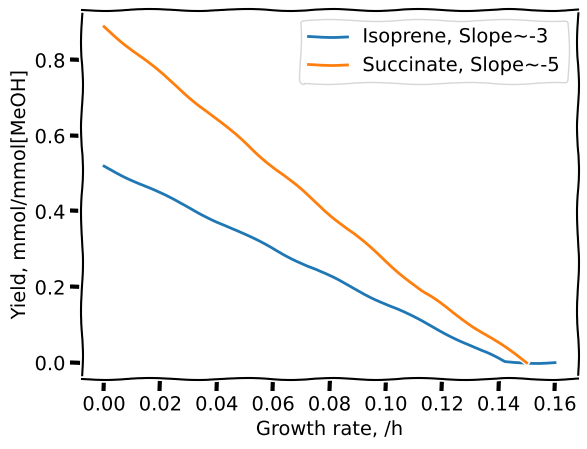

In [130]:
bio = np.linspace(.0,.15,5) # .0,.16,10
Substrate = 'meoh'
Product = 'succ[c]' #isoprene[c], 'succ[c]'
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
flux=10
Suc_List = list()
for bioi in bio:
    with model as md:
        md.reactions.get_by_id('BIOMASS').lower_bound = bioi
        md = set_ObjGSMM(md, Product)
        md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        Suc_List.append([bioi, Yield])

bio = np.linspace(.0,.16,10)
Substrate = 'meoh'
Product = 'isoprene[c]' 
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
flux=10
IP_List = list()
for bioi in bio:
    with model as md:
        md.reactions.get_by_id('BIOMASS').lower_bound = bioi
        md.reactions.get_by_id('Ex_glc_D').lower_bound = 0
        md = set_ObjGSMM(md, Product)
        md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        IP_List.append([bioi, Yield])
# visalization        
ipdata = np.array(IP_List)
sucdata = np.array(Suc_List)
m,n = np.polyfit(ipdata[:,0], ipdata[:,1], 1)
a,b = np.polyfit(sucdata[:,0], sucdata[:,1], 1)
print(m,n)
with plt.xkcd():
    plt.plot(ipdata[:,0], ipdata[:,1])
    plt.plot(sucdata[:,0], sucdata[:,1])
    plt.xlabel('Growth rate, /h')
    plt.ylabel('Yield, mmol/mmol[MeOH]')
    plt.legend([f'Isoprene, Slope~{int(m)}', f'Succinate, Slope~{int(a)}'])

# plt.savefig('Yields-VS-Growth_Isoprene+Suc_Opol.png')

In [131]:
bio = np.linspace(.01,.15,5)
Substrate = 'meoh'
flux=10
Product = ['mal_L[e]','lac_L[e]','acetone[e]','isoprene[e]'] 
PCol = {'acetone[e]':'b', 'isoprene[e]':'g', 'lac_L[e]':'c', 'mal_L[e]':'m'}
PMark = {'acetone[e]':'o', 'isoprene[e]':'d', 'lac_L[e]':'s', 'mal_L[e]':'x'}
YieldProd = dict()

for myProd in Product:
    Cnum = countCinFormula(model.metabolites.get_by_id(myProd).formula)
    Yield = list()
    for bioi in bio:
        with model as md:
            md.reactions.get_by_id('BIOMASS').lower_bound = bioi
            md.reactions.get_by_id('Ex_glc_D').lower_bound = 0
            md = set_ObjGSMM(md, myProd)
            md = set_SubFlux(md, [Substrate], 'Ex_glc_D', flux)
            sol = md.optimize()
            Yield.append(sol.fluxes['DM_{}'.format(myProd)]*Cnum/flux)
    YieldProd[myProd] = {'Yield':Yield, 'growth':list(bio), 'color':PCol[myProd], 'marker': PMark[myProd]}


/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


### Malate production

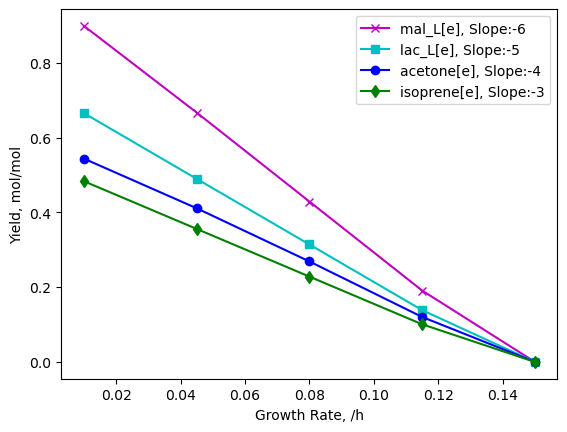

In [132]:
FigureName = 'ProdYields-VS-Growth'
for Target in YieldProd.keys():
    m,n = np.polyfit(YieldProd[Target]['growth'], YieldProd[Target]['Yield'], 1)
    plt.plot(YieldProd[Target]['growth'], YieldProd[Target]['Yield'], 
                # s = 20, 
                c = PCol[Target], 
                marker = PMark[Target],
                label = f'{Target}, Slope:{round(m)}')
plt.xlabel('Growth Rate, /h')
plt.ylabel('Yield, mol/mol')
plt.legend()
plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))
plt.show()

## Adjusting pathway activities
### Pathway activity report

In [133]:
RctFluxName = {'HEX1':6, 
               'G6PDH2':6, 
               'PYK':3,
               'PC':4,
               'MDH':4, 
               'PDHa1':3,
               'CSm':6, 
               'ICDOXSUCm':6,
               'AKGDH1':6,
               'SUCOASm':4,
               'SUCD2_u6m':4,
               'MDHm':4,
               # 'AKGMALtm':5, 
               'ICL':6, 
            #    'SUCDH_q6_m':4, 
            #    'MALSm':4, 
               'Ex_co2':1}

# [print(model.reactions.get_by_id(Rct)) for Rct in RctFluxName.keys()];

#### Finding metabolites in model

In [113]:
# Searching for metabolite IDs
# CheckMetName = 'Acetone'
# [print('{}:\t{}:\t{}:\t{}\n'.format(MetID.name, MetID.id, MetID.formula, MetID.annotation)) for MetID in model.metabolites.query(CheckMetName, 'name')];

CheckMetID = 'acetone[e]'
[print(f'{myRct.id}: {myRct.reaction}') for myRct in model.metabolites.get_by_id(CheckMetID).reactions];

Trans_acetone[c]: acetone[c] <=> acetone[e]


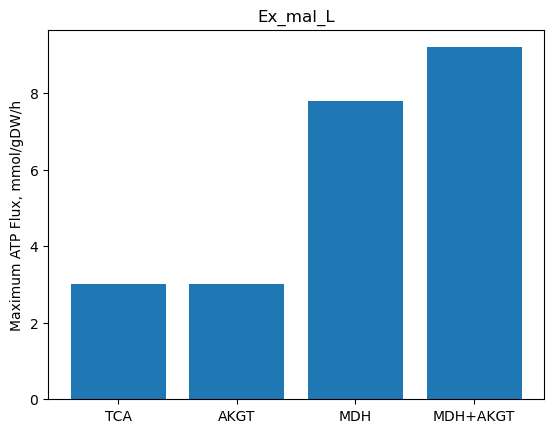

In [139]:
GlcEx = 'Ex_glc_D'
Substrate = 'meoh'
flux = 10
Target = 'Ex_mal_L' # Ex_mal_L
TarRate = 2.4
exp4all = dict()
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    mySol = md.optimize()
    # print(md.summary())
    exp4all['TCA'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['AKGT'] = mySol

with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH'] = mySol
    
with model as md :
    md.objective = 'ATPM'
    md = set_SubFlux(md, [Substrate], GlcEx, flux)
    md.reactions.get_by_id(Target).bounds = TarRate,100
    md.reactions.get_by_id('MDH').bounds = -1000,1000
    md.reactions.get_by_id('AKGMALtm').bounds = -1000,1000
    mySol = md.optimize()
    # print(md.summary())
    exp4all['MDH+AKGT'] = mySol

FigureName = 'PathFluxCond-VS-MaxATP'

ATPmax = [exp4all[Condition].objective_value for Condition in exp4all.keys()]
plt.bar(exp4all.keys(), ATPmax)
plt.ylabel('Maximum ATP Flux, mmol/gDW/h')
plt.title(Target)
# plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))
plt.show()


In [21]:
metid = 'mal_L[e]' 
exp4all = mySol
[print(f'{rct.id}\t{rct.reaction}\t{round(exp4all[rct.id])}') for rct in model.metabolites.get_by_id(metid).reactions if np.abs(exp4all[rct.id])>.1];

In [50]:
[print(f'{model.reactions.get_by_id(Rct).id} \t {model.reactions.get_by_id(Rct).reaction} \t {round(exp4all[Rct]*RctFluxName[Rct])}') for Rct in RctFluxName.keys()];

HEX1 	 atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c] 	 0
G6PDH2 	 g6p[c] + nadp[c] --> 6pgl[c] + h[c] + nadph[c] 	 0
PYK 	 adp[c] + h[c] + pep[c] --> atp[c] + pyr[c] 	 8
PC 	 atp[c] + hco3[c] + pyr[c] --> adp[c] + h[c] + oaa[c] + pi[c] 	 9
MDH 	 mal_L[c] + nad[c] --> h[c] + nadh[c] + oaa[c] 	 -9
PDHa1 	 h[m] + pyr[m] + thmpp[m] --> 2_Hydroxyethyl_ThPP[m] + co2[m] 	 4
CSm 	 accoa[m] + h2o[m] + oaa[m] --> cit[m] + coa[m] + h[m] 	 7
ICDOXSUCm 	 icit[m] + nad[m] --> h[m] + nadh[m] + oxasucc[m] 	 2
AKGDH1 	 akg[m] + 5.0 h[m] + thmpp[m] --> 3_Carboxy_1_hydroxypropyl_ThPP[m] + co2[m] 	 6
SUCOASm 	 atp[m] + coa[m] + succ[m] <=> adp[m] + pi[m] + succoa[m] 	 -4
SUCD2_u6m 	 q6[m] + succ[m] <=> fum[m] + q6h2[m] 	 0
MDHm 	 mal_L[m] + nad[m] <=> h[m] + nadh[m] + oaa[m] 	 5
ICL 	 icit[c] --> glx[c] + succ[c] 	 0
Ex_co2 	 co2[e] -->  	 3
